https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767

In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length


In [2]:

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)


In [3]:
generateData()

(array([[0, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 0, 1, 0],
        [1, 0, 1, ..., 0, 1, 0],
        [1, 1, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0]]), array([[0, 0, 0, ..., 1, 1, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 1, 1],
        [0, 1, 0, ..., 1, 1, 0],
        [1, 1, 0, ..., 0, 0, 1]]))

In [4]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [5]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [11]:
batchX_placeholder

<tf.Tensor 'Placeholder:0' shape=(5, 15) dtype=float32>

In [7]:
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [10]:
inputs_series[0]

<tf.Tensor 'unstack:0' shape=(5,) dtype=float32>

In [13]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

In [17]:

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [18]:

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.6784532


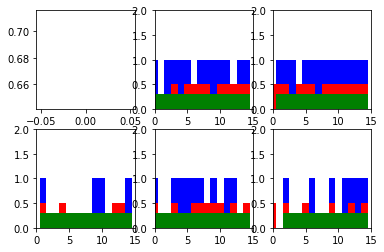

Step 100 Loss 0.68571


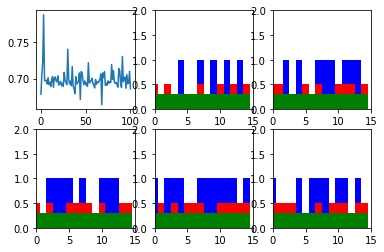

Step 200 Loss 0.69324684


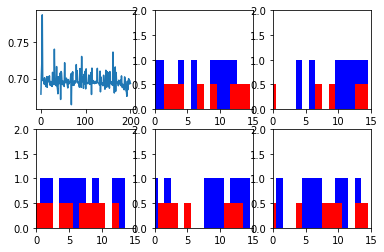

Step 300 Loss 0.58965725


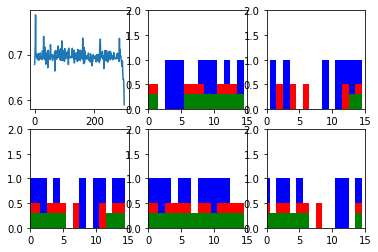

Step 400 Loss 0.079757705


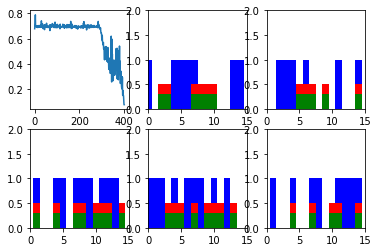

Step 500 Loss 0.0068472284


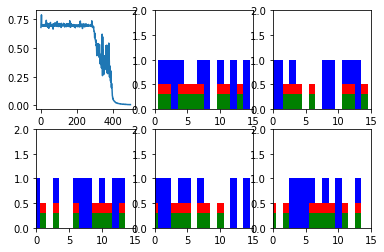

Step 600 Loss 0.0037850984


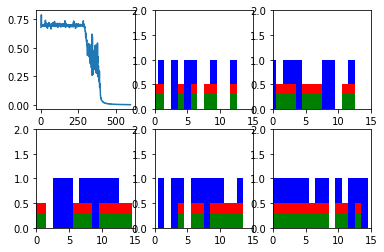

New data, epoch 1
Step 0 Loss 0.19179337


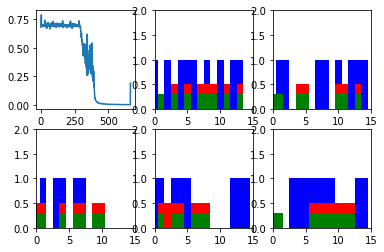

Step 100 Loss 0.0023197108


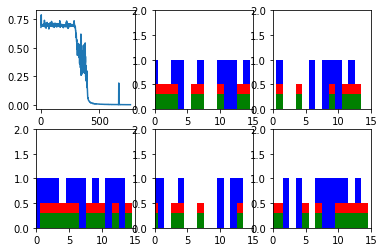

Step 200 Loss 0.0017529847


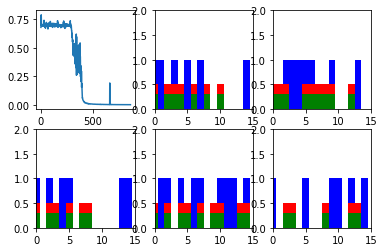

Step 300 Loss 0.0015446844


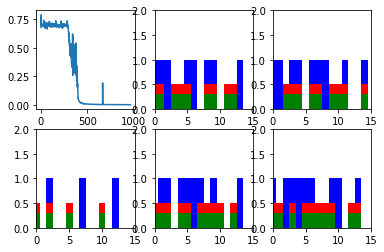

Step 400 Loss 0.0011713622


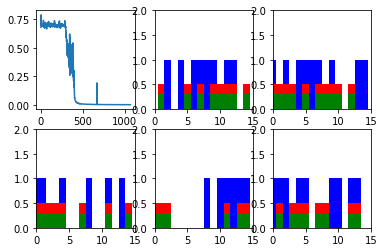

Step 500 Loss 0.0011965571


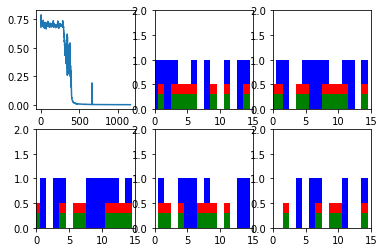

Step 600 Loss 0.0009785767


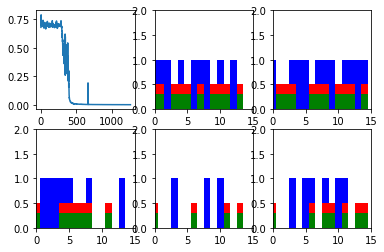

New data, epoch 2
Step 0 Loss 0.34598884


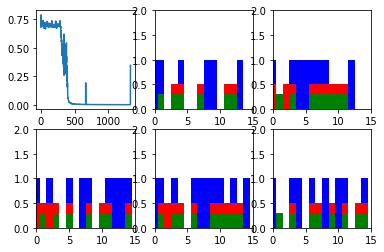

Step 100 Loss 0.0009304468


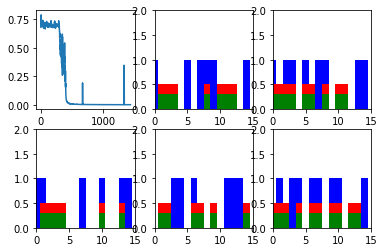

Step 200 Loss 0.00074716064


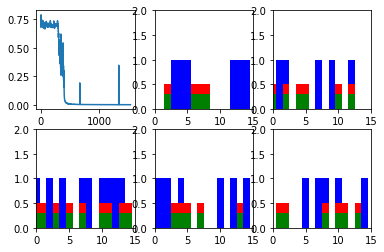

Step 300 Loss 0.0007394673


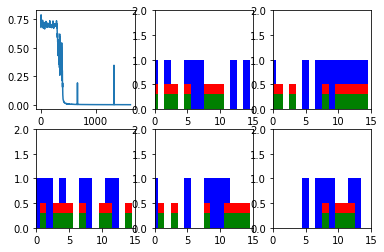

Step 400 Loss 0.0006866555


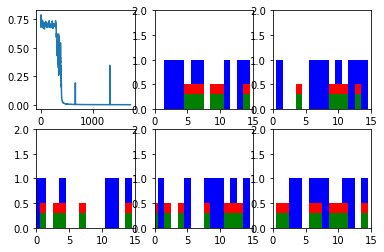

Step 500 Loss 0.0006261079


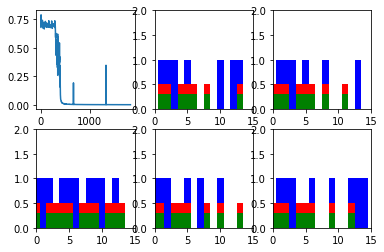

Step 600 Loss 0.00059651135


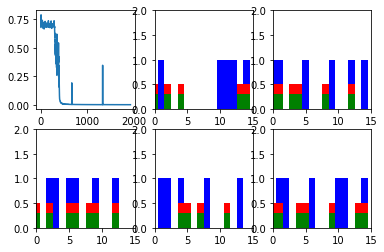

New data, epoch 3
Step 0 Loss 0.23081411


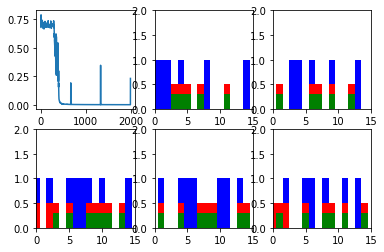

Step 100 Loss 0.00059516943


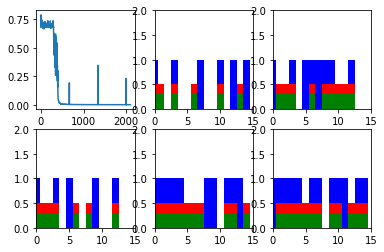

Step 200 Loss 0.00057779776


In [ ]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()